In [20]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score
from torch.utils.data import TensorDataset, DataLoader

from visualization import (
    plot_probability_heatmap, plot_learning_curves, plot_roc, plot_confusion,
    compare_grid, make_grid, model_prob_grid, save_animation
)


In [21]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')   # Check wether gpu is available

### The Mandelbrot set
The Mandelbrot set is a two-dimensional set that is defined in the complex plane as the complex numbers $c$ for which the function $f_c(z) = z^2 + c $ does not diverge to infinity when iterated starting at $z=0$.

Interesting properties:
- A point c belongs to the Mandelbrot set iff $|z| \leq 2$ for all $n \geq 0$


### Fourier Features

xxx

In [22]:
class FourierFeatures(nn.Module):
    """
        Gaussian Fourier Features
    """
    def __init__(self, in_dim=2, num_feats=256, sigma=10.0):
        super().__init__()
        B = torch.randn(in_dim, num_feats)
        self.register_buffer("B", B)

    def forward(self, x):
        proj = 2 * np.pi * x @ self.B
        return torch.cat([proj.sin(), proj.cos()], dim=-1)

### Creating a dataset

In [23]:
def mandelbrot_grid_dataset(nx=750, ny=750, xlim=(-2.0, 1.0), ylim =(-1.5, 1.5), max_iter=1000):
    xs = np.linspace(xlim[0], xlim[1], nx)
    ys = np.linspace(ylim[0], ylim[1], ny)
    X, Y = np.meshgrid(xs, ys, indexing="xy")
    
    C = X + 1j * Y
    Z = np.zeros_like(C)
    mask = np.ones(C.shape, dtype=bool)

    for _ in range(max_iter):
        Z[mask] = Z[mask] * Z[mask] + C[mask]
        # Update mask for those that remain within radius 2
        mask[mask] = (np.abs(Z[mask]) <= 2.0)

    # If after max_iter still True, it's considered inside the set
    in_set = mask
    return X, Y, in_set

### Neural Network

In [24]:
class NeuralNetFourierFeatures(nn.Module):
    def __init__(self, num_hidden_layers=3, num_feats=256):
        super().__init__()
        self.ff = FourierFeatures(in_dim=2, num_feats=num_feats)

        layers = [
            nn.Linear(2*num_feats, 32),
            nn.ReLU(),
        ]

        for _ in range(num_hidden_layers):
            layers.append(
                nn.Linear(32, 32)
            )
            layers.append(
                nn.ReLU()
            )
        
        # Output
        layers.append(
            nn.Linear(32, 1)
        )
        self.sigmoid_layer = nn.Sigmoid()
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = self.ff(x)
        x = self.network(x)
        # return self.sigmoid_layer(x)
        return x

### Training Loop

In [25]:
from torch.utils.data import TensorDataset, DataLoader

def train(model, X_train, y_train, X_val, y_val, num_epoch=20, batch_size=16, lr=0.0001, criterion=nn.BCEWithLogitsLoss(), visualize=False, visualize_epochs=10, save_checkpoints=False):
    # Load model into GPU
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) # Convert target to float and unsqueeze for BCEWithLogitsLoss
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1) # Convert target to float and unsqueeze for BCEWithLogitsLoss

    # Create a TensorDataset and DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    train_losses = []
    val_losses = []

    saved_ckpts = []

    # Training loop
    for epoch in range(num_epoch):
        model.train() # Set the model to training mode
        train_loss = 0
        for batch_X, batch_y in train_loader:
            # Load into GPU
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * batch_X.size(0)
        
        model.eval() # Set the model to training mode
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                # Load into GPU
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)

                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)

                val_loss += loss.item() * batch_X.size(0)
        
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_val_loss = val_loss / len(val_loader.dataset)
        
        # Store losses
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        print(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")
        
        # every visualize_epochs epochs:
        if visualize and (epoch + 1) % visualize_epochs == 0:
            plot_probability_heatmap(model, device, epoch, outdir="images")
        
        if save_checkpoints and ((epoch + 1) % visualize_epochs == 0 or (epoch + 1) == num_epoch):
            ckpt_path = os.path.join("images/checkpoints", f"ckpt_epoch_{epoch+1:03d}.pt")
            torch.save(model.state_dict(), ckpt_path)
            saved_ckpts.append(ckpt_path)

    # Plot the learning curves
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label="Training loss")
    plt.plot(val_losses, label="Validation loss")
    plt.title("Learning Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return model

### Testing Loop

In [26]:
def test(model, X_test, y_test, threshold=0.5):
    # Convert data to Pytorch tensors
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    model.to(device)
    # Evaluation mode
    model.eval() 

    with torch.no_grad():
        # Load into GPU
        X_test_tensor = X_test_tensor.to(device)
        y_prob_tensor = model(X_test_tensor)
        
        # Convert probabilities to binary predictions (0 or 1)
        y_pred = (y_prob_tensor > threshold).float()

        y_true_np = y_test_tensor.cpu().numpy()
        y_pred_np = y_pred.cpu().numpy()
        y_prob_np = y_prob_tensor.cpu().numpy()

        # Calculate metrics
        auc = roc_auc_score(y_true_np, y_prob_np)
        print(f"Test AUC: {auc:.4f}\n")
        
        accuracy = accuracy_score(y_true_np, y_pred_np)
        print(f"Test Accuracy: {accuracy:.4f}\n")
        
        print("Classification Report:")
        print(classification_report(y_true_np, y_pred_np))
        
        print("Confusion Matrix:")
        print(confusion_matrix(y_true_np, y_pred_np))

        f1 = f1_score(y_true_np, y_pred_np, pos_label=1)
        tn, fp, fn, tp = confusion_matrix(y_true_np, y_pred_np).ravel()

        report = {
            "accuracy": accuracy,
            "f1_score_positive": f1,
            "auc": auc,
            "true_positives": tp,
            "false_positives": fp,
            "true_negatives": tn,
            "false_negatives": fn
        }
    
    return report

### Visualization

Device: cpu
Epoch: 1, Train Loss: 0.1459240403110451, Val Loss: 0.023440778306855096
Epoch: 2, Train Loss: 0.02264284150355392, Val Loss: 0.019792448101639746
Epoch: 3, Train Loss: 0.020286876916488013, Val Loss: 0.018237054985695417
Epoch: 4, Train Loss: 0.018885460161301826, Val Loss: 0.017312522377239334
Epoch: 5, Train Loss: 0.017915639650821685, Val Loss: 0.016727479314075575
Saved: images/prob_epoch_5.png
Epoch: 6, Train Loss: 0.017219049018687673, Val Loss: 0.016339802662067943
Epoch: 7, Train Loss: 0.016634925821754666, Val Loss: 0.01576053152024746
Epoch: 8, Train Loss: 0.01614102033217748, Val Loss: 0.015337233942415979
Epoch: 9, Train Loss: 0.015697165882123842, Val Loss: 0.015015991839269797
Epoch: 10, Train Loss: 0.015339163990947936, Val Loss: 0.014847433786524667
Saved: images/prob_epoch_10.png
Epoch: 11, Train Loss: 0.015004153921173678, Val Loss: 0.01453285870363315
Epoch: 12, Train Loss: 0.014718751469022698, Val Loss: 0.014141741363737319
Epoch: 13, Train Loss: 0.014

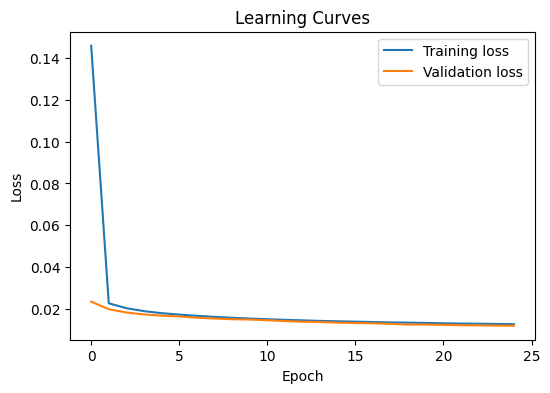

Saved: images/compare_grid.png
Test AUC: 0.9998

Test Accuracy: 0.9942

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     46838
         1.0       1.00      0.97      0.98      9412

    accuracy                           0.99     56250
   macro avg       0.99      0.98      0.99     56250
weighted avg       0.99      0.99      0.99     56250

Confusion Matrix:
[[46793    45]
 [  283  9129]]

Report: {'accuracy': 0.9941688888888889, 'f1_score_positive': 0.9823523081889595, 'auc': 0.9998201475959301, 'true_positives': np.int64(9129), 'false_positives': np.int64(45), 'true_negatives': np.int64(46793), 'false_negatives': np.int64(283)}


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Generate boolean labels on a grid (fast)
X2d, Y2d, in_set = mandelbrot_grid_dataset(nx=750, ny=750, max_iter=1000)

# Flatten to (N, 2) and (N,)
X = np.stack([X2d.ravel(), Y2d.ravel()], axis=-1).astype(np.float32)
y = in_set.ravel().astype(np.float32)

# Stratified split
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42, shuffle=True
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, stratify=y_tmp, random_state=42, shuffle=True
)

# Model
model = NeuralNetFourierFeatures(num_hidden_layers=4)

# Train
model = train(
    model, X_train, y_train, X_val, y_val,
    num_epoch=25, batch_size=2048, lr=1e-3,
    visualize=True, visualize_epochs=5, save_checkpoints=True
)

# Build GT mask once (vectorized)
# Same xlim/ylim/res as used for plots
xlim, ylim, res = (-2,1), (-1.5,1.5), (400,400)
X2d, Y2d, gt_mask = mandelbrot_grid_dataset(nx=res[0], ny=res[1], xlim=xlim, ylim=ylim, max_iter=1000)

# Get model probabilities on the same grid
X, Y, grid = make_grid(xlim, ylim, res)
prob = model_prob_grid(model, device, grid, res)

# Save comparison grid
compare_grid(gt_mask, prob, threshold=0.5, xlim=xlim, ylim=ylim,
             outpath="images/compare_grid.png")


# Test
report = test(model, X_test, y_test, threshold=0.5)
print("\nReport:", report)

In [28]:
checkpoint_paths = [
    "images/checkpoints/ckpt_epoch_010.pt",
    "images/checkpoints/ckpt_epoch_005.pt",
    "images/checkpoints/ckpt_epoch_005.pt",
    "images/checkpoints/ckpt_epoch_015.pt",
    "images/checkpoints/ckpt_epoch_020.pt",
]
build_model_fn = lambda: NeuralNetFourierFeatures(num_hidden_layers=4)
save_animation(checkpoint_paths, build_model_fn, device,
               xlim=(-2,1), ylim=(-1.5,1.5), res=(400,400),
               outpath="images/training.gif")


Saved: images/training.gif
